In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.fft import fftshift, ifft

# Define the grid size
n = 32

# Define the characteristic function of the sum of chi-squared variables
def characteristic_function(t, grid_size):
    phi = 1
    for k1 in range(1, grid_size + 1):
        for k2 in range(1, grid_size + 1):
            k_squared = k1**2 + k2**2
            if k1 == k2:
                phi *= (1 - 2j * t / k_squared) ** (-1 / 2)
            else:
                phi *= (1 - 2j * t / k_squared) ** (-1)
    return phi

def integrand(t, s, grid_size):
    # This is the integrand for the inverse Fourier transform to compute the PDF
    return np.real(characteristic_function(t, grid_size) * np.exp(-1j * t * s))

# Compute the PDF using numerical integration
def pdf_via_integration(s, grid_size, t_max=100):
    # Perform the integration for each value of s
    result, error = quad(integrand, -t_max, t_max, args=(s, grid_size))
    return result / (2 * np.pi)

def sanity_check_pdf_normalization(s_vals, pdf_vals):
    # Numerical integration using the trapezoidal rule to check if the PDF integrates to 1
    integral = np.trapz(pdf_vals, s_vals)
    return integral

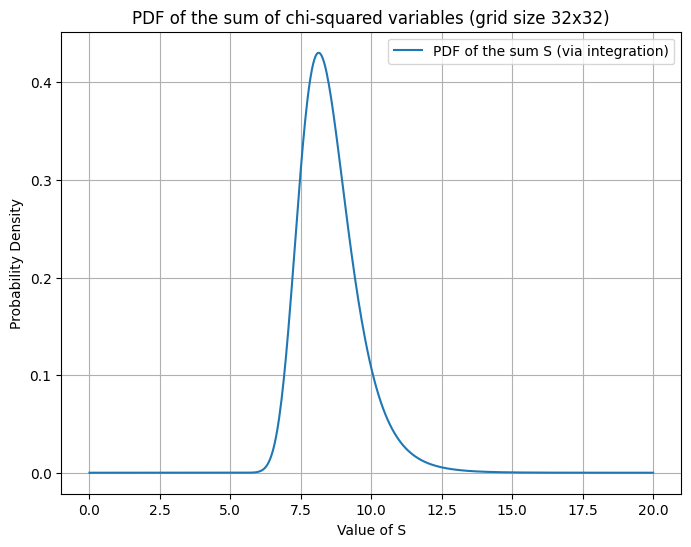

In [10]:
# Generate a range of s values (from 0 to a reasonable upper limit, say 20)
t_max = 400
s_vals_integration = np.linspace(0, 20, 500)
pdf_vals_integration = np.array([pdf_via_integration(s, n, t_max) for s in s_vals_integration])

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(s_vals_integration, pdf_vals_integration, label='PDF of the sum S (via integration)')
plt.title(f'PDF of the sum of chi-squared variables (grid size {n}x{n})')
plt.xlabel('Value of S')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Perform the sanity check
normalization_check = sanity_check_pdf_normalization(s_vals_integration, pdf_vals_integration)

# Display the result of the sanity check
normalization_check

/var/folders/6f/3d7pjjnx0199mxxn8jxjr2y80000gn/T/ipykernel_14624/427799104.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(pdf_vals, s_vals)


np.float64(0.9999984319521416)